# Geez Character Recognition with MAML


#### Importing Library

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import random
from tqdm import tqdm
import copy
import cv2

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Loading and Preprocessing Data

In [3]:

class AmharicDataset:
    """
    Dataset class for Amharic character recognition optimized for meta-learning
    """
    def __init__(
        self,
        data_folder,
        img_size=(28, 28),
        split=[0.7, 0.15, 0.15]
    ):
        self.data_folder = data_folder
        self.img_size = img_size
        
        # Get all character folders
        self.character_folders = []
        for char_folder in os.listdir(data_folder):
            folder_path = os.path.join(data_folder, char_folder)
            if os.path.isdir(folder_path):
                self.character_folders.append(folder_path)
        
        # Shuffle and split into train/val/test
        random.shuffle(self.character_folders)
        
        num_chars = len(self.character_folders)
        train_size = int(num_chars * split[0])
        val_size = int(num_chars * split[1])
        
        self.train_folders = self.character_folders[:train_size]
        self.val_folders = self.character_folders[train_size:train_size+val_size]
        self.test_folders = self.character_folders[train_size+val_size:]
        
        print(f"Found {num_chars} Amharic characters")
        print(f"Train: {len(self.train_folders)}, Val: {len(self.val_folders)}, Test: {len(self.test_folders)}")
        
        # Define transforms
        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        
        # Data augmentation for training
        self.train_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.RandomRotation(10),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    
    def get_images_from_folder(self, folder_path, num_samples=None, augment=False):
        """Get a specified number of images from a folder"""
        transform = self.train_transform if augment else self.transform
        image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
                      if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        
        if num_samples is not None and num_samples <= len(image_paths):
            selected_paths = random.sample(image_paths, num_samples)
        else:
            selected_paths = image_paths
        
        images = []
        for img_path in selected_paths:
            try:
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = transform(img)
                images.append(img)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                # Create a blank image as fallback
                img = torch.zeros((1, *self.img_size), dtype=torch.float32)
                images.append(img)
        
        # Stack images
        if images:
            return torch.stack(images)
        else:
            return torch.zeros((0, 1, *self.img_size), dtype=torch.float32)
    
    def sample_batch(self, batch_type, n_way, k_shot, q_shot, batch_size):
        """
        Sample a batch of tasks for meta-learning
        
        Args:
            batch_type: 'train', 'val', or 'test'
            n_way: N-way classification (number of classes per task)
            k_shot: K-shot learning (number of support examples per class)
            q_shot: Number of query examples per class
            batch_size: Number of tasks in the batch
            
        Returns:
            support_images: [batch_size, n_way*k_shot, 1, H, W]
            support_labels: [batch_size, n_way*k_shot]
            query_images: [batch_size, n_way*q_shot, 1, H, W]
            query_labels: [batch_size, n_way*q_shot]
        """
        if batch_type == 'train':
            folders = self.train_folders
            augment = True
        elif batch_type == 'val':
            folders = self.val_folders
            augment = False
        else:
            folders = self.test_folders
            augment = False
        
        # Ensure we have enough classes
        if len(folders) < n_way:
            raise ValueError(f"Not enough classes for {batch_type}. " 
                            f"Found {len(folders)}, need {n_way}")
        
        support_images = []
        support_labels = []
        query_images = []
        query_labels = []
        
        for _ in range(batch_size):
            # Sample N classes for this task
            task_classes = random.sample(folders, n_way)
            
            task_support_images = []
            task_support_labels = []
            task_query_images = []
            task_query_labels = []
            
            for class_idx, class_folder in enumerate(task_classes):
                # Get K+Q images for this class
                all_images = self.get_images_from_folder(
                    class_folder, k_shot + q_shot, augment=augment
                )
                
                if len(all_images) < k_shot + q_shot:
                    print(f"Warning: Not enough images in {class_folder}. Found {len(all_images)}, need {k_shot + q_shot}.")
                    # Pad with duplicates if needed
                    if len(all_images) > 0:
                        while len(all_images) < k_shot + q_shot:
                            all_images = torch.cat([all_images, all_images[:1]], dim=0)
                    else:
                        # Create blank images if the folder is empty
                        all_images = torch.zeros((k_shot + q_shot, 1, *self.img_size), dtype=torch.float32)
                
                # Split into support and query
                support_imgs = all_images[:k_shot]
                query_imgs = all_images[k_shot:k_shot+q_shot]
                
                # Create labels (class indices)
                support_lbls = torch.full((k_shot,), class_idx, dtype=torch.long)
                query_lbls = torch.full((q_shot,), class_idx, dtype=torch.long)
                
                task_support_images.append(support_imgs)
                task_support_labels.append(support_lbls)
                task_query_images.append(query_imgs)
                task_query_labels.append(query_lbls)
            
            # Concatenate across classes
            task_support_images = torch.cat(task_support_images, dim=0)
            task_support_labels = torch.cat(task_support_labels, dim=0)
            task_query_images = torch.cat(task_query_images, dim=0)
            task_query_labels = torch.cat(task_query_labels, dim=0)
            
            support_images.append(task_support_images)
            support_labels.append(task_support_labels)
            query_images.append(task_query_images)
            query_labels.append(task_query_labels)
        
        # Stack along batch dimension
        support_images = torch.stack(support_images)
        support_labels = torch.stack(support_labels)
        query_images = torch.stack(query_images)
        query_labels = torch.stack(query_labels)
        
        return support_images, support_labels, query_images, query_labels


### Model Arctecture 

In [4]:
class ConvBlock(nn.Module):
    """
    Convolutional block with batch normalization
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size, 
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class AmharicCNN(nn.Module):
    """
    CNN model for Amharic character recognition
    """
    def __init__(self, num_classes=5, input_channels=1):
        super(AmharicCNN, self).__init__()
        self.features = nn.Sequential(
            ConvBlock(input_channels, 32),
            nn.MaxPool2d(2, 2),
            ConvBlock(32, 64),
            nn.MaxPool2d(2, 2),
            ConvBlock(64, 128),
            nn.MaxPool2d(2, 2)
        )
        
        # Calculate the output size after convolutions and pooling
        # For 28x28 input: 28 -> 14 -> 7 -> 3 (after 3 max pooling layers)
        feature_size = 3  # Depends on input size
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * feature_size * feature_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


### MAML Techniques 

In [5]:
class MAML:
    """
    Model-Agnostic Meta-Learning implementation for Amharic character recognition
    """
    def __init__(
        self,
        model,
        inner_lr=0.01,
        outer_lr=0.001,
        inner_steps=5,
        first_order=False
    ):
        self.model = model.to(device)
        self.inner_lr = inner_lr
        self.outer_lr = outer_lr
        self.inner_steps = inner_steps
        self.first_order = first_order  # Whether to use first-order approximation
        
        self.meta_optimizer = optim.Adam(self.model.parameters(), lr=self.outer_lr)
        self.criterion = nn.CrossEntropyLoss()
    
    def adapt(self, support_images, support_labels, first_order=None):
        """
        Perform inner loop adaptation on a single task
        
        Args:
            support_images: [n_way*k_shot, 1, H, W]
            support_labels: [n_way*k_shot]
            first_order: Whether to use first-order approximation
                        (if None, use the default value)
        
        Returns:
            adapted_params: List of parameters after adaptation
        """
        if first_order is None:
            first_order = self.first_order
        
        # Clone model parameters for adaptation
        params = [p.clone() for p in self.model.parameters()]
        
        # Move data to device
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)
        
        for _ in range(self.inner_steps):
            # Forward pass with adapted parameters
            logits = self.forward_with_params(support_images, params)
            loss = self.criterion(logits, support_labels)
            
            # Compute gradients
            grads = torch.autograd.grad(loss, params, create_graph=not first_order)
            
            # Update parameters
            params = [p - self.inner_lr * g for p, g in zip(params, grads)]
        
        return params
    
    def forward_with_params(self, x, params):
        """
        Forward pass using the provided parameters
        
        Args:
            x: Input tensor
            params: List of parameters to use
        
        Returns:
            Model output using the provided parameters
        """
        # Extract the parameters for each layer
        param_idx = 0
        
        # Forward through the feature layers
        for layer in self.model.features:
            if isinstance(layer, ConvBlock):
                # Extract parameters for conv, bn layers
                conv_w = params[param_idx]
                param_idx += 1
                bn_w = params[param_idx]
                param_idx += 1
                bn_b = params[param_idx]
                param_idx += 1
                
                # Apply conv layer
                x = F.conv2d(x, conv_w, stride=layer.conv.stride, 
                             padding=layer.conv.padding)
                
                # Apply batch norm
                x = F.batch_norm(x, running_mean=None, running_var=None, 
                                weight=bn_w, bias=bn_b, training=True)
                
                # Apply ReLU
                x = F.relu(x, inplace=True)
            else:
                # Pass through other layers without parameters (like MaxPool)
                x = layer(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Forward through the classifier layers
        for layer in self.model.classifier:
            if isinstance(layer, nn.Linear):
                # Extract parameters for linear layer
                w = params[param_idx]
                param_idx += 1
                b = params[param_idx]
                param_idx += 1
                
                # Apply linear layer
                x = F.linear(x, w, b)
            elif isinstance(layer, nn.ReLU):
                x = F.relu(x, inplace=True)
            elif isinstance(layer, nn.Dropout):
                x = F.dropout(x, p=layer.p, training=self.model.training)
        
        return x
    
    def meta_learn(self, support_images, support_labels, query_images, query_labels):
        """
        Perform meta-learning update on a batch of tasks
        
        Args:
            support_images: [batch_size, n_way*k_shot, 1, H, W]
            support_labels: [batch_size, n_way*k_shot]
            query_images: [batch_size, n_way*q_shot, 1, H, W]
            query_labels: [batch_size, n_way*q_shot]
        
        Returns:
            meta_loss: Loss on the query set after adaptation
            accuracy: Accuracy on the query set after adaptation
        """
        batch_size = support_images.size(0)
        meta_loss = 0.0
        correct = 0
        total = 0
        
        # Move data to device
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)
        
        self.meta_optimizer.zero_grad()
        
        for task_idx in range(batch_size):
            # Get task data
            task_support_images = support_images[task_idx]
            task_support_labels = support_labels[task_idx]
            task_query_images = query_images[task_idx]
            task_query_labels = query_labels[task_idx]
            
            # Adapt to the task
            adapted_params = self.adapt(task_support_images, task_support_labels)
            
            # Evaluate on query set
            task_query_logits = self.forward_with_params(task_query_images, adapted_params)
            task_loss = self.criterion(task_query_logits, task_query_labels)
            
            # Accumulate loss
            meta_loss += task_loss
            
            # Calculate accuracy
            _, predicted = task_query_logits.max(1)
            total += task_query_labels.size(0)
            correct += predicted.eq(task_query_labels).sum().item()
        
        # Average loss across tasks
        meta_loss = meta_loss / batch_size
        
        # Compute gradients and update meta-parameters
        meta_loss.backward()
        self.meta_optimizer.step()
        
        accuracy = 100.0 * correct / total
        return meta_loss.item(), accuracy
    
    def evaluate(self, data_generator, n_way, k_shot, q_shot, num_tasks=100, split='val'):
        """
        Evaluate the model on a set of tasks
        
        Args:
            data_generator: AmharicDataset instance
            n_way: N-way classification
            k_shot: K-shot learning
            q_shot: Number of query examples per class
            num_tasks: Number of tasks to evaluate on
            split: 'val' or 'test'
        
        Returns:
            avg_loss: Average loss across tasks
            avg_accuracy: Average accuracy across tasks
        """
        total_loss = 0.0
        total_accuracy = 0.0
        
        # Set model to evaluation mode
        self.model.eval()
        
        with torch.no_grad():
            for _ in tqdm(range(num_tasks), desc=f"Evaluating on {split}"):
                # Sample a task
                support_images, support_labels, query_images, query_labels = data_generator.sample_batch(
                    split, n_way, k_shot, q_shot, batch_size=1
                )
                
                # Squeeze batch dimension
                support_images = support_images.squeeze(0)
                support_labels = support_labels.squeeze(0)
                query_images = query_images.squeeze(0)
                query_labels = query_labels.squeeze(0)
                
                # Enable gradients for inner loop
                with torch.enable_grad():
                    # Adapt to the task
                    adapted_params = self.adapt(support_images, support_labels, first_order=True)
                
                # Evaluate on query set
                query_images = query_images.to(device)
                query_labels = query_labels.to(device)
                
                query_logits = self.forward_with_params(query_images, adapted_params)
                loss = self.criterion(query_logits, query_labels)
                
                # Calculate accuracy
                _, predicted = query_logits.max(1)
                accuracy = 100.0 * predicted.eq(query_labels).sum().item() / query_labels.size(0)
                
                total_loss += loss.item()
                total_accuracy += accuracy
        
        # Set model back to training mode
        self.model.train()
        
        return total_loss / num_tasks, total_accuracy / num_tasks
    
    def save_model(self, path):
        """Save the model"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.meta_optimizer.state_dict(),
            'inner_lr': self.inner_lr,
            'outer_lr': self.outer_lr,
            'inner_steps': self.inner_steps,
            'first_order': self.first_order
        }, path)
    
    def load_model(self, path):
        """Load the model"""
        checkpoint = torch.load(path, map_location=device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.meta_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.inner_lr = checkpoint['inner_lr']
        self.outer_lr = checkpoint['outer_lr']
        self.inner_steps = checkpoint['inner_steps']
        self.first_order = checkpoint['first_order']

def train_maml(
    data_generator,
    model,
    n_way=10,
    k_shot=5,
    q_shot=5,
    inner_lr=0.01,
    outer_lr=0.001,
    inner_steps=5,
    meta_batch_size=4,
    epochs=50,
    tasks_per_epoch=100,
    eval_interval=5,
    first_order=False,
    save_path='maml_amharic.pth'
):
    """
    Train a MAML model for Amharic character recognition
    
    Args:
        data_generator: AmharicDataset instance
        model: Model to train
        n_way: N-way classification
        k_shot: K-shot learning
        q_shot: Number of query examples per class
        inner_lr: Inner loop learning rate
        outer_lr: Outer loop learning rate
        inner_steps: Number of inner loop steps
        meta_batch_size: Number of tasks per batch
        epochs: Number of epochs
        tasks_per_epoch: Number of tasks per epoch
        eval_interval: Interval for evaluation
        first_order: Whether to use first-order approximation
        save_path: Path to save the model
    
    Returns:
        train_losses: List of training losses
        train_accuracies: List of training accuracies
        val_losses: List of validation losses
        val_accuracies: List of validation accuracies
    """
    # Initialize MAML
    maml = MAML(
        model=model,
        inner_lr=inner_lr,
        outer_lr=outer_lr,
        inner_steps=inner_steps,
        first_order=first_order
    )
    
    # Set model to training mode
    model.train()
    
    # Initialize lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # Best validation accuracy
    best_val_accuracy = 0.0
    
    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        
        # Train on tasks_per_epoch tasks
        with tqdm(total=tasks_per_epoch, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for task_idx in range(tasks_per_epoch):
                # Sample a batch of tasks
                support_images, support_labels, query_images, query_labels = data_generator.sample_batch(
                    'train', n_way, k_shot, q_shot, meta_batch_size
                )
                
                # Meta-learn on the batch
                task_loss, task_accuracy = maml.meta_learn(
                    support_images, support_labels, query_images, query_labels
                )
                
                epoch_loss += task_loss
                epoch_accuracy += task_accuracy
                
                pbar.update(1)
                pbar.set_postfix({
                    'loss': f"{task_loss:.4f}",
                    'acc': f"{task_accuracy:.2f}%"
                })
        
        # Average metrics for the epoch
        avg_loss = epoch_loss / tasks_per_epoch
        avg_accuracy = epoch_accuracy / tasks_per_epoch
        
        train_losses.append(avg_loss)
        train_accuracies.append(avg_accuracy)
        
        print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.2f}%")
        
        # Evaluate on validation set every eval_interval epochs
        if (epoch + 1) % eval_interval == 0 or epoch == 0 or epoch == epochs - 1:
            val_loss, val_accuracy = maml.evaluate(
                data_generator, n_way, k_shot, q_shot, num_tasks=50, split='val'
            )
            
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
            
            # Save best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                maml.save_model(save_path)
                print(f"Saved best model with validation accuracy: {val_accuracy:.2f}%")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

Found 142 Amharic characters
Train: 99, Val: 21, Test: 22

=== Dataset Analysis ===

Total training characters: 99
Total validation characters: 21
Total test characters: 22
Characters common to both train and test: 0
Characters common to both val and test: 0

No overlapping characters between training and test sets.
This is a challenging few-shot learning scenario!
Using a higher shot count (K=10) and more inner steps (inner_steps=10)...

Starting modified MAML training for challenging scenario...


Epoch 1/100: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s, loss=0.5286, acc=78.00%]


Epoch 1 - Train Loss: 0.7806, Train Accuracy: 72.02%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 14.70it/s]


Epoch 1 - Val Loss: 0.2750, Val Accuracy: 91.40%
Saved best model with validation accuracy: 91.40%


Epoch 2/100: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s, loss=0.6661, acc=75.50%]


Epoch 2 - Train Loss: 0.6548, Train Accuracy: 75.18%


Epoch 3/100: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s, loss=0.4886, acc=81.50%]


Epoch 3 - Train Loss: 0.5722, Train Accuracy: 78.30%


Epoch 4/100: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s, loss=0.5347, acc=78.50%]


Epoch 4 - Train Loss: 0.5605, Train Accuracy: 78.96%


Epoch 5/100: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s, loss=0.5077, acc=80.50%]


Epoch 5 - Train Loss: 0.5011, Train Accuracy: 81.21%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 14.56it/s]


Epoch 5 - Val Loss: 0.1439, Val Accuracy: 95.88%
Saved best model with validation accuracy: 95.88%


Epoch 6/100: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.5440, acc=81.00%]


Epoch 6 - Train Loss: 0.4897, Train Accuracy: 81.78%


Epoch 7/100: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s, loss=0.4767, acc=81.00%]


Epoch 7 - Train Loss: 0.4936, Train Accuracy: 81.33%


Epoch 8/100: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s, loss=0.6832, acc=71.50%]


Epoch 8 - Train Loss: 0.4961, Train Accuracy: 81.36%


Epoch 9/100: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s, loss=0.4657, acc=81.00%]


Epoch 9 - Train Loss: 0.5712, Train Accuracy: 77.68%


Epoch 10/100: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s, loss=0.6085, acc=74.50%]


Epoch 10 - Train Loss: 0.5781, Train Accuracy: 77.18%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 14.88it/s]


Epoch 10 - Val Loss: 0.2462, Val Accuracy: 91.80%


Epoch 11/100: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s, loss=0.6920, acc=69.50%]


Epoch 11 - Train Loss: 0.6563, Train Accuracy: 73.02%


Epoch 12/100: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.8767, acc=61.00%]


Epoch 12 - Train Loss: 0.7308, Train Accuracy: 69.83%


Epoch 13/100: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s, loss=0.8458, acc=60.00%]


Epoch 13 - Train Loss: 0.8026, Train Accuracy: 65.23%


Epoch 14/100: 100%|██████████| 100/100 [00:37<00:00,  2.63it/s, loss=0.9894, acc=58.50%]


Epoch 14 - Train Loss: 0.8223, Train Accuracy: 65.43%


Epoch 15/100: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s, loss=0.7958, acc=67.50%]


Epoch 15 - Train Loss: 0.8346, Train Accuracy: 64.83%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 14.59it/s]


Epoch 15 - Val Loss: 0.3905, Val Accuracy: 86.44%


Epoch 16/100: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s, loss=0.6893, acc=73.00%]


Epoch 16 - Train Loss: 0.8278, Train Accuracy: 64.91%


Epoch 17/100: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s, loss=0.7398, acc=66.00%]


Epoch 17 - Train Loss: 0.8705, Train Accuracy: 62.37%


Epoch 18/100: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s, loss=0.9643, acc=59.00%]


Epoch 18 - Train Loss: 0.8649, Train Accuracy: 61.91%


Epoch 19/100: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s, loss=0.7967, acc=68.50%]


Epoch 19 - Train Loss: 0.8114, Train Accuracy: 65.58%


Epoch 20/100: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s, loss=0.8331, acc=66.00%]


Epoch 20 - Train Loss: 0.8391, Train Accuracy: 64.42%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 14.16it/s]


Epoch 20 - Val Loss: 0.6214, Val Accuracy: 70.76%


Epoch 21/100: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s, loss=0.9150, acc=61.00%]


Epoch 21 - Train Loss: 0.8793, Train Accuracy: 61.66%


Epoch 22/100: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s, loss=0.7511, acc=70.00%]


Epoch 22 - Train Loss: 0.8697, Train Accuracy: 61.33%


Epoch 23/100: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s, loss=0.8855, acc=66.00%]


Epoch 23 - Train Loss: 0.9423, Train Accuracy: 57.63%


Epoch 24/100: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s, loss=0.6480, acc=72.50%]


Epoch 24 - Train Loss: 0.9053, Train Accuracy: 60.84%


Epoch 25/100: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s, loss=1.0059, acc=59.00%]


Epoch 25 - Train Loss: 0.8757, Train Accuracy: 62.77%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 14.96it/s]


Epoch 25 - Val Loss: 0.5041, Val Accuracy: 81.16%


Epoch 26/100: 100%|██████████| 100/100 [00:37<00:00,  2.68it/s, loss=0.8569, acc=64.00%]


Epoch 26 - Train Loss: 0.8727, Train Accuracy: 62.23%


Epoch 27/100: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.8349, acc=66.00%]


Epoch 27 - Train Loss: 0.8834, Train Accuracy: 63.10%


Epoch 28/100: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s, loss=0.7590, acc=68.00%]


Epoch 28 - Train Loss: 0.8003, Train Accuracy: 67.16%


Epoch 29/100: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s, loss=0.8679, acc=61.50%]


Epoch 29 - Train Loss: 0.8132, Train Accuracy: 65.46%


Epoch 30/100: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s, loss=0.6812, acc=76.50%]


Epoch 30 - Train Loss: 0.8374, Train Accuracy: 64.91%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 14.77it/s]


Epoch 30 - Val Loss: 0.3545, Val Accuracy: 86.92%


Epoch 31/100: 100%|██████████| 100/100 [00:37<00:00,  2.63it/s, loss=0.6216, acc=78.00%]


Epoch 31 - Train Loss: 0.7910, Train Accuracy: 68.17%


Epoch 32/100: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.7387, acc=70.50%]


Epoch 32 - Train Loss: 0.7372, Train Accuracy: 70.94%


Epoch 33/100: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s, loss=0.8470, acc=68.00%]


Epoch 33 - Train Loss: 0.8031, Train Accuracy: 67.12%


Epoch 34/100: 100%|██████████| 100/100 [00:37<00:00,  2.65it/s, loss=0.7609, acc=73.50%]


Epoch 34 - Train Loss: 0.8891, Train Accuracy: 63.03%


Epoch 35/100: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s, loss=0.7190, acc=72.00%]


Epoch 35 - Train Loss: 0.8570, Train Accuracy: 65.56%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 15.07it/s]


Epoch 35 - Val Loss: 0.5502, Val Accuracy: 76.92%


Epoch 36/100: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.6876, acc=75.50%]


Epoch 36 - Train Loss: 0.7866, Train Accuracy: 69.17%


Epoch 37/100: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s, loss=0.6645, acc=75.00%]


Epoch 37 - Train Loss: 0.7093, Train Accuracy: 74.14%


Epoch 38/100: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.7403, acc=74.50%]


Epoch 38 - Train Loss: 0.7006, Train Accuracy: 74.46%


Epoch 39/100: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s, loss=0.6519, acc=77.50%]


Epoch 39 - Train Loss: 0.7036, Train Accuracy: 74.40%


Epoch 40/100: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s, loss=0.6646, acc=79.50%]


Epoch 40 - Train Loss: 0.6899, Train Accuracy: 74.73%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 14.95it/s]


Epoch 40 - Val Loss: 0.3823, Val Accuracy: 89.60%


Epoch 41/100: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.7747, acc=71.00%]


Epoch 41 - Train Loss: 0.7406, Train Accuracy: 74.17%


Epoch 42/100: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s, loss=0.7274, acc=76.00%]


Epoch 42 - Train Loss: 0.7579, Train Accuracy: 73.50%


Epoch 43/100: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s, loss=0.7036, acc=74.00%]


Epoch 43 - Train Loss: 0.6767, Train Accuracy: 76.50%


Epoch 44/100: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s, loss=0.6002, acc=77.50%]


Epoch 44 - Train Loss: 0.6218, Train Accuracy: 78.87%


Epoch 45/100: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s, loss=0.6650, acc=74.00%]


Epoch 45 - Train Loss: 0.6456, Train Accuracy: 78.06%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 14.56it/s]


Epoch 45 - Val Loss: 0.2294, Val Accuracy: 95.20%


Epoch 46/100: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s, loss=0.4778, acc=84.50%]


Epoch 46 - Train Loss: 0.6506, Train Accuracy: 76.94%


Epoch 47/100: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s, loss=0.6530, acc=77.50%]


Epoch 47 - Train Loss: 0.6898, Train Accuracy: 75.48%


Epoch 48/100: 100%|██████████| 100/100 [00:37<00:00,  2.65it/s, loss=0.7785, acc=65.00%]


Epoch 48 - Train Loss: 0.7043, Train Accuracy: 75.71%


Epoch 49/100: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s, loss=0.7654, acc=70.50%]


Epoch 49 - Train Loss: 0.6513, Train Accuracy: 77.75%


Epoch 50/100: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.4941, acc=83.00%]


Epoch 50 - Train Loss: 0.6627, Train Accuracy: 76.72%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 15.37it/s]


Epoch 50 - Val Loss: 0.2783, Val Accuracy: 94.16%


Epoch 51/100: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s, loss=0.5166, acc=80.50%]


Epoch 51 - Train Loss: 0.6257, Train Accuracy: 78.67%


Epoch 52/100: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s, loss=0.6827, acc=75.50%]


Epoch 52 - Train Loss: 0.6144, Train Accuracy: 78.28%


Epoch 53/100: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s, loss=0.6893, acc=68.50%]


Epoch 53 - Train Loss: 0.5847, Train Accuracy: 79.56%


Epoch 54/100: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.5557, acc=81.50%]


Epoch 54 - Train Loss: 0.5759, Train Accuracy: 79.40%


Epoch 55/100: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s, loss=0.5062, acc=81.00%]


Epoch 55 - Train Loss: 0.5883, Train Accuracy: 78.58%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 15.50it/s]


Epoch 55 - Val Loss: 0.1889, Val Accuracy: 95.36%


Epoch 56/100: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s, loss=0.4608, acc=83.50%]


Epoch 56 - Train Loss: 0.5505, Train Accuracy: 80.44%


Epoch 57/100: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s, loss=0.6369, acc=75.00%]


Epoch 57 - Train Loss: 0.5410, Train Accuracy: 80.89%


Epoch 58/100: 100%|██████████| 100/100 [00:37<00:00,  2.65it/s, loss=0.3945, acc=85.00%]


Epoch 58 - Train Loss: 0.5142, Train Accuracy: 81.88%


Epoch 59/100: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s, loss=0.4278, acc=85.00%]


Epoch 59 - Train Loss: 0.5088, Train Accuracy: 81.62%


Epoch 60/100: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s, loss=0.4666, acc=82.50%]


Epoch 60 - Train Loss: 0.4855, Train Accuracy: 82.73%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 14.45it/s]


Epoch 60 - Val Loss: 0.1939, Val Accuracy: 95.08%


Epoch 61/100: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s, loss=0.5057, acc=80.00%]


Epoch 61 - Train Loss: 0.4877, Train Accuracy: 82.92%


Epoch 62/100: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s, loss=0.4875, acc=82.50%]


Epoch 62 - Train Loss: 0.4726, Train Accuracy: 83.98%


Epoch 63/100: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s, loss=0.6385, acc=81.00%]


Epoch 63 - Train Loss: 0.4933, Train Accuracy: 82.98%


Epoch 64/100: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s, loss=0.5491, acc=81.00%]


Epoch 64 - Train Loss: 0.5323, Train Accuracy: 81.09%


Epoch 65/100: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s, loss=0.3806, acc=85.50%]


Epoch 65 - Train Loss: 0.5405, Train Accuracy: 80.64%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 15.80it/s]


Epoch 65 - Val Loss: 0.1804, Val Accuracy: 96.40%
Saved best model with validation accuracy: 96.40%


Epoch 66/100: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s, loss=0.5521, acc=81.00%]


Epoch 66 - Train Loss: 0.5388, Train Accuracy: 80.98%


Epoch 67/100: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s, loss=0.7560, acc=77.00%]


Epoch 67 - Train Loss: 0.5528, Train Accuracy: 80.73%


Epoch 68/100: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s, loss=0.4211, acc=87.50%]


Epoch 68 - Train Loss: 0.5633, Train Accuracy: 80.00%


Epoch 69/100: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s, loss=0.3410, acc=89.50%]


Epoch 69 - Train Loss: 0.5115, Train Accuracy: 82.23%


Epoch 70/100: 100%|██████████| 100/100 [00:37<00:00,  2.65it/s, loss=0.5616, acc=78.00%]


Epoch 70 - Train Loss: 0.4978, Train Accuracy: 82.50%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 15.77it/s]


Epoch 70 - Val Loss: 0.1934, Val Accuracy: 95.92%


Epoch 71/100: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s, loss=0.3896, acc=85.00%]


Epoch 71 - Train Loss: 0.4564, Train Accuracy: 84.28%


Epoch 72/100: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.5547, acc=81.00%]


Epoch 72 - Train Loss: 0.5010, Train Accuracy: 82.52%


Epoch 73/100: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s, loss=0.5036, acc=81.50%]


Epoch 73 - Train Loss: 0.5467, Train Accuracy: 80.86%


Epoch 74/100: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s, loss=0.6161, acc=79.50%]


Epoch 74 - Train Loss: 0.5433, Train Accuracy: 81.28%


Epoch 75/100: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s, loss=0.6083, acc=76.50%]


Epoch 75 - Train Loss: 0.5564, Train Accuracy: 80.39%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 14.95it/s]


Epoch 75 - Val Loss: 0.2441, Val Accuracy: 94.60%


Epoch 76/100: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s, loss=0.3595, acc=89.50%]


Epoch 76 - Train Loss: 0.5454, Train Accuracy: 81.06%


Epoch 77/100: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s, loss=0.4970, acc=83.00%]


Epoch 77 - Train Loss: 0.5213, Train Accuracy: 81.58%


Epoch 78/100: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.3119, acc=90.50%]


Epoch 78 - Train Loss: 0.4840, Train Accuracy: 83.23%


Epoch 79/100: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s, loss=0.3588, acc=89.00%]


Epoch 79 - Train Loss: 0.5163, Train Accuracy: 82.34%


Epoch 80/100: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.5999, acc=78.00%]


Epoch 80 - Train Loss: 0.5380, Train Accuracy: 81.20%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 14.89it/s]


Epoch 80 - Val Loss: 0.2248, Val Accuracy: 95.68%


Epoch 81/100: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s, loss=0.4837, acc=86.00%]


Epoch 81 - Train Loss: 0.5367, Train Accuracy: 81.30%


Epoch 82/100: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s, loss=0.5105, acc=85.50%]


Epoch 82 - Train Loss: 0.5497, Train Accuracy: 80.97%


Epoch 83/100: 100%|██████████| 100/100 [00:37<00:00,  2.65it/s, loss=0.4285, acc=87.00%]


Epoch 83 - Train Loss: 0.5327, Train Accuracy: 81.60%


Epoch 84/100: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s, loss=0.8334, acc=82.50%]


Epoch 84 - Train Loss: 0.5962, Train Accuracy: 79.47%


Epoch 85/100: 100%|██████████| 100/100 [00:37<00:00,  2.65it/s, loss=0.4226, acc=85.50%]


Epoch 85 - Train Loss: 0.5534, Train Accuracy: 81.28%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Epoch 85 - Val Loss: 0.2711, Val Accuracy: 95.20%


Epoch 86/100: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s, loss=0.5258, acc=82.50%]


Epoch 86 - Train Loss: 0.5326, Train Accuracy: 82.38%


Epoch 87/100: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.7117, acc=73.00%]


Epoch 87 - Train Loss: 0.5546, Train Accuracy: 81.83%


Epoch 88/100: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s, loss=0.6443, acc=78.00%]


Epoch 88 - Train Loss: 0.5926, Train Accuracy: 80.83%


Epoch 89/100: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s, loss=0.6382, acc=80.50%]


Epoch 89 - Train Loss: 0.6667, Train Accuracy: 78.00%


Epoch 90/100: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s, loss=0.8015, acc=73.50%]


Epoch 90 - Train Loss: 0.6976, Train Accuracy: 77.15%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 13.62it/s]


Epoch 90 - Val Loss: 0.5122, Val Accuracy: 89.52%


Epoch 91/100: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s, loss=0.8446, acc=72.00%]


Epoch 91 - Train Loss: 0.7112, Train Accuracy: 76.66%


Epoch 92/100: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s, loss=0.6533, acc=76.00%]


Epoch 92 - Train Loss: 0.7229, Train Accuracy: 76.20%


Epoch 93/100: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s, loss=0.5805, acc=83.50%]


Epoch 93 - Train Loss: 0.7251, Train Accuracy: 76.09%


Epoch 94/100: 100%|██████████| 100/100 [00:38<00:00,  2.56it/s, loss=0.4767, acc=83.50%]


Epoch 94 - Train Loss: 0.7239, Train Accuracy: 75.23%


Epoch 95/100: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s, loss=0.5728, acc=87.50%]


Epoch 95 - Train Loss: 0.6863, Train Accuracy: 76.77%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 14.87it/s]


Epoch 95 - Val Loss: 0.4060, Val Accuracy: 92.76%


Epoch 96/100: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s, loss=0.8437, acc=66.00%]


Epoch 96 - Train Loss: 0.6861, Train Accuracy: 76.52%


Epoch 97/100: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s, loss=0.5689, acc=83.50%]


Epoch 97 - Train Loss: 0.6399, Train Accuracy: 78.17%


Epoch 98/100: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s, loss=0.8734, acc=66.00%]


Epoch 98 - Train Loss: 0.6457, Train Accuracy: 77.50%


Epoch 99/100: 100%|██████████| 100/100 [00:38<00:00,  2.56it/s, loss=0.5618, acc=83.50%]


Epoch 99 - Train Loss: 0.6233, Train Accuracy: 78.56%


Epoch 100/100: 100%|██████████| 100/100 [00:38<00:00,  2.56it/s, loss=0.5869, acc=79.50%]


Epoch 100 - Train Loss: 0.6048, Train Accuracy: 78.97%


Evaluating on val: 100%|██████████| 50/50 [00:03<00:00, 13.62it/s]
/tmp/ipykernel_2560443/1141000000.py:476: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch

Epoch 100 - Val Loss: 0.3093, Val Accuracy: 93.12%

=== Evaluating MAML on test set ===



Evaluating on test: 100%|██████████| 100/100 [00:06<00:00, 14.72it/s]


MAML Test Accuracy: 97.26%


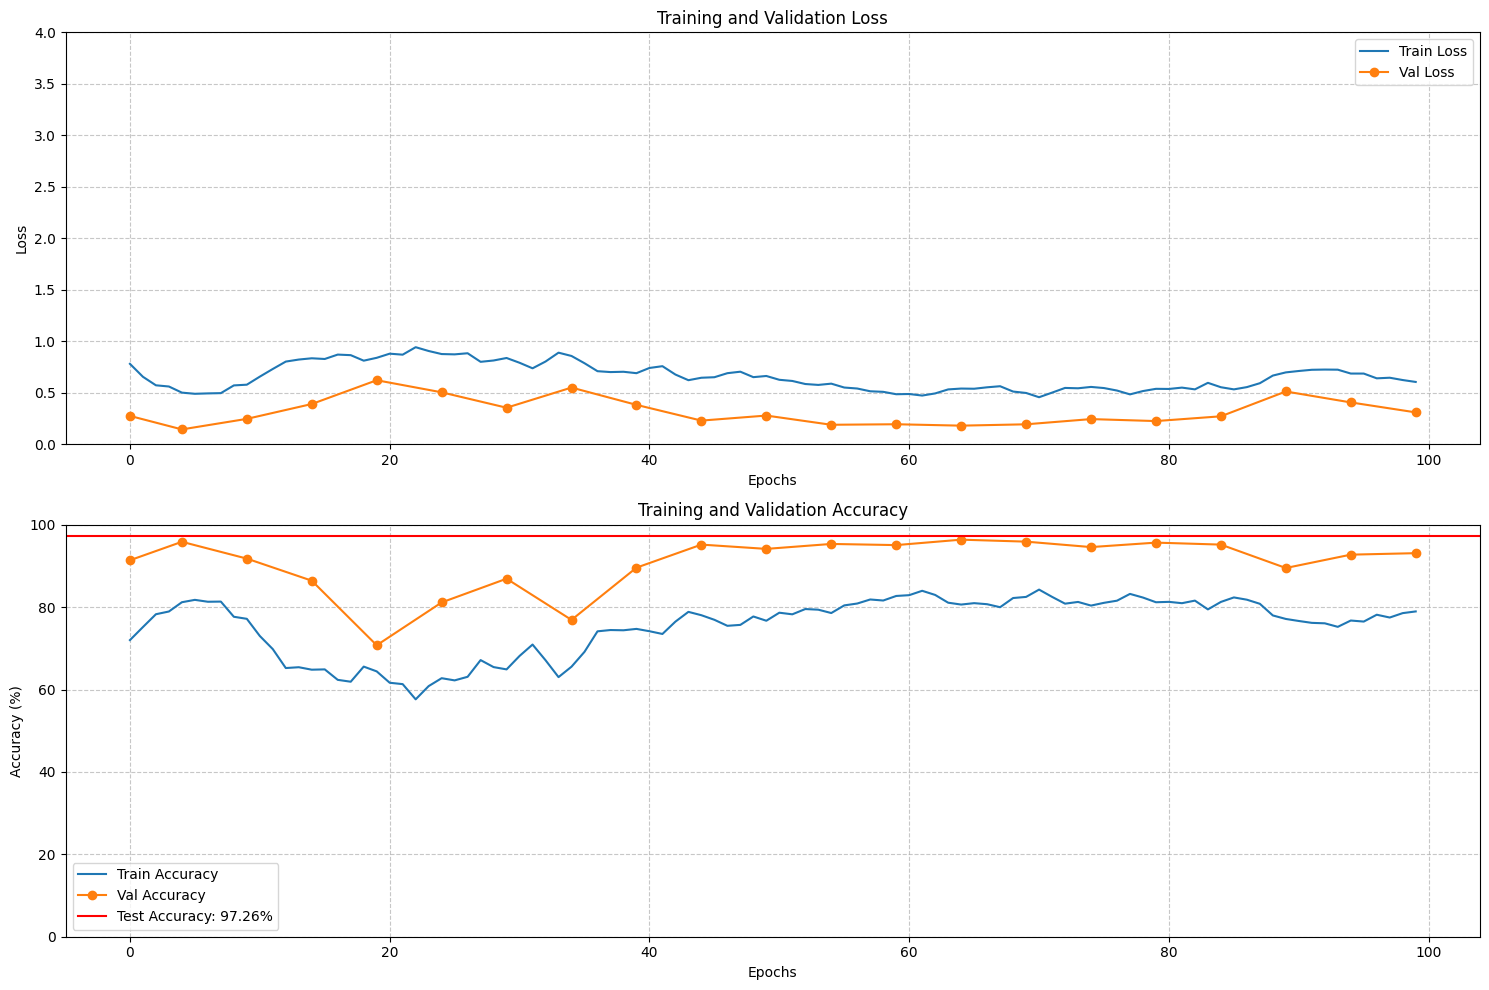

In [6]:
def fine_tune_model(model, data_generator, learning_rate=0.001, epochs=20):
    """
    Fine-tune the model on all available Amharic characters after meta-training
    
    Args:
        model: Pre-trained model
        data_generator: AmharicDataset instance
        learning_rate: Learning rate for fine-tuning
        epochs: Number of epochs for fine-tuning
    
    Returns:
        fine_tuned_model: Fine-tuned model
    """
    # Combine all available training and validation folders
    all_folders = data_generator.train_folders + data_generator.val_folders
    n_way = len(all_folders)  # Use all available classes
    
    print(f"Fine-tuning on {n_way} Amharic characters")
    
    # Create a new classifier with the correct number of classes
    feature_size = 3  # Same as in the model definition
    model.classifier[-1] = nn.Linear(512, n_way)
    model = model.to(device)
    
    # Prepare fine-tuning data (all available examples per class)
    print("Preparing fine-tuning dataset...")
    train_images = []
    train_labels = []
    
    for class_idx, folder in enumerate(tqdm(all_folders)):
        # Get all images for this class, with a maximum of 50 per class to keep memory usage reasonable
        class_images = data_generator.get_images_from_folder(folder, 50, augment=True)
        if len(class_images) > 0:
            class_labels = torch.full((len(class_images),), class_idx, dtype=torch.long)
            
            train_images.append(class_images)
            train_labels.append(class_labels)
    
    # Concatenate data
    train_images = torch.cat(train_images, dim=0)
    train_labels = torch.cat(train_labels, dim=0)
    
    print(f"Fine-tuning dataset prepared: {train_images.size(0)} images across {n_way} classes")
    
    # Define optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Fine-tuning loop
    model.train()
    batch_size = 64
    
    for epoch in range(epochs):
        # Shuffle data
        indices = torch.randperm(train_images.size(0))
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        
        # Train in batches
        num_batches = 0
        for i in range(0, train_images.size(0), batch_size):
            # Get batch indices
            batch_indices = indices[i:i+batch_size]
            
            # Get batch data
            batch_images = train_images[batch_indices].to(device)
            batch_labels = train_labels[batch_indices].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = outputs.max(1)
            accuracy = 100.0 * predicted.eq(batch_labels).sum().item() / batch_labels.size(0)
            
            epoch_loss += loss.item() * batch_labels.size(0)
            epoch_accuracy += accuracy * batch_labels.size(0)
            num_batches += 1
        
        # Average metrics for the epoch
        avg_loss = epoch_loss / train_images.size(0)
        avg_accuracy = epoch_accuracy / train_images.size(0)
        
        print(f"Fine-tuning Epoch {epoch+1}/{epochs} - "
              f"Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%")
    
    return model

def evaluate_model(model, data_generator, num_samples=50):
    """
    Evaluate the fine-tuned model on the test set
    
    Args:
        model: Fine-tuned model
        data_generator: AmharicDataset instance
        num_samples: Maximum number of samples per class to evaluate on
    
    Returns:
        accuracy: Test accuracy
    """
    model.eval()
    
    # Get test data
    test_folders = data_generator.test_folders
    n_way = len(test_folders)  # Number of test classes
    
    print(f"Evaluating on {n_way} test classes")
    
    test_images = []
    test_labels = []
    
    for class_idx, folder in enumerate(tqdm(test_folders, desc="Preparing test data")):
        # Get all images for this class (up to num_samples)
        class_images = data_generator.get_images_from_folder(folder, num_samples)
        if len(class_images) > 0:
            class_labels = torch.full((len(class_images),), class_idx, dtype=torch.long)
            
            test_images.append(class_images)
            test_labels.append(class_labels)
    
    # Concatenate data
    test_images = torch.cat(test_images, dim=0)
    test_labels = torch.cat(test_labels, dim=0)
    
    print(f"Test dataset prepared: {test_images.size(0)} images across {n_way} classes")
    
    # Evaluate in batches
    batch_size = 64
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i in range(0, test_images.size(0), batch_size):
            # Get batch data
            batch_images = test_images[i:i+batch_size].to(device)
            batch_labels = test_labels[i:i+batch_size].to(device)
            
            # Forward pass
            outputs = model(batch_images)
            
            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += batch_labels.size(0)
            correct += predicted.eq(batch_labels).sum().item()
    
    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    return accuracy
def main():
    # Parameters
    DATA_FOLDER = "/home/hailemicaelyimer/Desktop/ACR/dataset"
    IMG_SIZE = (28, 28)
    N_WAY = 5       # 5-way classification for meta-training
    K_SHOT = 5      # 5-shot learning
    Q_SHOT = 5      # 5 query examples per class
    META_BATCH_SIZE = 4
    INNER_LR = 0.01
    OUTER_LR = 0.001
    INNER_STEPS = 5
    EPOCHS = 50
    TASKS_PER_EPOCH = 100
    EVAL_INTERVAL = 5
    FIRST_ORDER = True  # Use first-order approximation for faster training
    SAVE_PATH = 'maml_amharic.pth'
    
    # Create data generator
    data_generator = AmharicDataset(
        data_folder=DATA_FOLDER,
        img_size=IMG_SIZE
    )
    
    # Create model
    model = AmharicCNN(
        num_classes=N_WAY,
        input_channels=1
    )
    
    # Train MAML
    train_losses, train_accuracies, val_losses, val_accuracies = train_maml(
        data_generator=data_generator,
        model=model,
        n_way=N_WAY,
        k_shot=K_SHOT,
        q_shot=Q_SHOT,
        inner_lr=INNER_LR,
        outer_lr=OUTER_LR,
        inner_steps=INNER_STEPS,
        meta_batch_size=META_BATCH_SIZE,
        epochs=EPOCHS,
        tasks_per_epoch=TASKS_PER_EPOCH,
        eval_interval=EVAL_INTERVAL,
        first_order=FIRST_ORDER,
        save_path=SAVE_PATH
    )
    
    # Load best model
    best_model = AmharicCNN(num_classes=N_WAY, input_channels=1)
    best_model = best_model.to(device)
    checkpoint = torch.load(SAVE_PATH, map_location=device)
    best_model.load_state_dict(checkpoint['model_state_dict'])
    
    # Initialize MAML with best model
    maml = MAML(
        model=best_model,
        inner_lr=INNER_LR,
        outer_lr=OUTER_LR,
        inner_steps=INNER_STEPS,
        first_order=FIRST_ORDER
    )
    
    # Directly evaluate on test set using meta-learning
    print("\n=== Evaluating MAML on test set ===\n")
    test_loss, test_accuracy = maml.evaluate(
        data_generator=data_generator,
        n_way=N_WAY,
        k_shot=K_SHOT,
        q_shot=Q_SHOT,
        num_tasks=100,  # Evaluate on more tasks for reliable results
        split='test'
    )
    
    print(f"MAML Test Accuracy: {test_accuracy:.2f}%")
    
    # Plot results with corrected plotting function
    plot_results_fixed(train_losses, train_accuracies, val_losses, val_accuracies, test_accuracy)

def plot_results_fixed(train_losses, train_accuracies, val_losses, val_accuracies, test_accuracy):
    """Plot training and validation results with proper handling of different array lengths"""
    plt.figure(figsize=(15, 10))
    
    # Plot losses
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    
    # Safely plot validation losses by creating appropriate x-coordinates
    if len(val_losses) > 0:
        # Create evenly spaced indices for validation points
        val_indices = np.linspace(0, len(train_losses)-1, len(val_losses)).astype(int)
        plt.plot(val_indices, val_losses, 'o-', label='Val Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(0, 4)

    # Plot accuracies
    plt.subplot(2, 1, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    
    if len(val_accuracies) > 0:
        # Same approach for validation accuracies
        val_indices = np.linspace(0, len(train_accuracies)-1, len(val_accuracies)).astype(int)
        plt.plot(val_indices, val_accuracies, 'o-', label='Val Accuracy')
    
    # Add test accuracy as horizontal line
    plt.axhline(y=test_accuracy, color='r', linestyle='-', label=f'Test Accuracy: {test_accuracy:.2f}%')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.ylim([0, 100])  # Set y-axis limits for accuracy plot
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig('maml_amharic_results.png')
    plt.show()

# Function to examine overlap between train and test sets
def analyze_dataset_overlap(data_generator):
    """Analyze overlap between training and test character sets"""
    # Get character names
    train_chars = [os.path.basename(folder) for folder in data_generator.train_folders]
    val_chars = [os.path.basename(folder) for folder in data_generator.val_folders]
    test_chars = [os.path.basename(folder) for folder in data_generator.test_folders]
    
    # Find common characters
    common_train_test = set(train_chars).intersection(set(test_chars))
    common_val_test = set(val_chars).intersection(set(test_chars))
    
    print(f"Total training characters: {len(train_chars)}")
    print(f"Total validation characters: {len(val_chars)}")
    print(f"Total test characters: {len(test_chars)}")
    print(f"Characters common to both train and test: {len(common_train_test)}")
    print(f"Characters common to both val and test: {len(common_val_test)}")
    
    if common_train_test:
        print("\nSome example overlapping characters:")
        for char in list(common_train_test)[:5]:  # Show first 5 examples
            print(f"- {char}")
    
    return common_train_test, common_val_test

# Function to evaluate only on overlapping characters
def evaluate_on_overlapping_chars(maml, data_generator, n_way, k_shot, q_shot):
    """Evaluate MAML only on character classes that appear in both train and test sets"""
    # Find overlapping characters
    train_chars = [os.path.basename(folder) for folder in data_generator.train_folders]
    test_chars = [os.path.basename(folder) for folder in data_generator.test_folders]
    common_chars = set(train_chars).intersection(set(test_chars))
    
    if len(common_chars) < n_way:
        print(f"Warning: Not enough overlapping characters for {n_way}-way classification.")
        print(f"Found {len(common_chars)} overlapping characters. Adjusting n_way.")
        n_way = min(n_way, len(common_chars))
    
    print(f"Evaluating MAML on {n_way}-way tasks using only overlapping characters")
    
    # Get folders for overlapping characters
    test_overlap_folders = []
    for folder in data_generator.test_folders:
        if os.path.basename(folder) in common_chars:
            test_overlap_folders.append(folder)
    
    # Evaluate on overlapping characters
    total_loss = 0.0
    total_accuracy = 0.0
    num_tasks = 50
    
    # Set model to evaluation mode
    maml.model.eval()
    
    with tqdm(total=num_tasks, desc="Evaluating on overlapping characters") as pbar:
        for _ in range(num_tasks):
            # Sample a task using only overlapping characters
            if len(test_overlap_folders) < n_way:
                # If not enough overlapping folders, use what we have
                task_classes = test_overlap_folders
            else:
                # Otherwise sample n_way classes
                task_classes = random.sample(test_overlap_folders, n_way)
            
            task_support_images = []
            task_support_labels = []
            task_query_images = []
            task_query_labels = []
            
            for class_idx, class_folder in enumerate(task_classes):
                # Get images for this class
                all_images = data_generator.get_images_from_folder(class_folder, k_shot + q_shot)
                
                if len(all_images) < k_shot + q_shot:
                    print(f"Warning: Not enough images in {class_folder}. Duplicating...")
                    # Duplicate existing images if needed
                    while len(all_images) < k_shot + q_shot:
                        all_images = torch.cat([all_images, all_images[:1]], dim=0)
                
                # Split into support and query
                support_imgs = all_images[:k_shot]
                query_imgs = all_images[k_shot:k_shot+q_shot]
                
                # Create labels
                support_lbls = torch.full((k_shot,), class_idx, dtype=torch.long)
                query_lbls = torch.full((q_shot,), class_idx, dtype=torch.long)
                
                task_support_images.append(support_imgs)
                task_support_labels.append(support_lbls)
                task_query_images.append(query_imgs)
                task_query_labels.append(query_lbls)
            
            # Concatenate
            task_support_images = torch.cat(task_support_images, dim=0)
            task_support_labels = torch.cat(task_support_labels, dim=0)
            task_query_images = torch.cat(task_query_images, dim=0)
            task_query_labels = torch.cat(task_query_labels, dim=0)
            
            # Adapt to the task
            with torch.enable_grad():
                adapted_params = maml.adapt(task_support_images, task_support_labels, first_order=True)
            
            # Evaluate on query set
            task_query_images = task_query_images.to(device)
            task_query_labels = task_query_labels.to(device)
            
            with torch.no_grad():
                query_logits = maml.forward_with_params(task_query_images, adapted_params)
                loss = maml.criterion(query_logits, task_query_labels)
                
                # Calculate accuracy
                _, predicted = query_logits.max(1)
                accuracy = 100.0 * predicted.eq(task_query_labels).sum().item() / task_query_labels.size(0)
                
                total_loss += loss.item()
                total_accuracy += accuracy
            
            pbar.update(1)
            pbar.set_postfix({"acc": f"{accuracy:.2f}%"})
    
    # Set model back to training mode
    maml.model.train()
    
    avg_loss = total_loss / num_tasks
    avg_accuracy = total_accuracy / num_tasks
    
    print(f"Overlap Test Loss: {avg_loss:.4f}, Overlap Test Accuracy: {avg_accuracy:.2f}%")
    
    return avg_loss, avg_accuracy
if __name__ == "__main__":
    # Create data generator first to analyze dataset
    data_generator = AmharicDataset(
        data_folder="/home/hailemicaelyimer/Desktop/ACR/dataset",
        img_size=(28, 28)
    )
    
    # Analyze dataset overlap
    print("\n=== Dataset Analysis ===\n")
    common_train_test, common_val_test = analyze_dataset_overlap(data_generator)
    
    # If there are common characters between train and test, we can proceed with normal evaluation
    # Otherwise, we'll need to use a different approach
    
    if common_train_test or common_val_test:
        print("\nFound overlapping characters between training and test sets.")
        print("Proceeding with standard MAML evaluation...\n")
        main()
    else:
        print("\nNo overlapping characters between training and test sets.")
        print("This is a challenging few-shot learning scenario!")
        print("Using a higher shot count (K=10) and more inner steps (inner_steps=10)...\n")
        
                # Modified parameters for challenging scenario
        DATA_FOLDER = "/home/hailemicaelyimer/Desktop/ACR/dataset"
        IMG_SIZE = (28, 28)
        N_WAY = 5
        K_SHOT = 15      # Increase from 10 to 15 shots for better adaptation
        Q_SHOT = 10      # Keep 10 query examples for evaluation
        META_BATCH_SIZE = 4
        INNER_LR = 0.1   # Increase from 0.05 to 0.1 for faster adaptation
        OUTER_LR = 0.001
        INNER_STEPS = 15 # Increase from 10 to 15 inner steps
        EPOCHS = 100
        TASKS_PER_EPOCH = 100
        EVAL_INTERVAL = 5
        FIRST_ORDER = True
        SAVE_PATH = 'mamll_amharic_challenging.pth'
        
        # Create model
        model = AmharicCNN(
            num_classes=N_WAY,
            input_channels=1
        )
        
        print("Starting modified MAML training for challenging scenario...")
        
        # Train MAML with modified parameters
        train_losses, train_accuracies, val_losses, val_accuracies = train_maml(
            data_generator=data_generator,
            model=model,
            n_way=N_WAY,
            k_shot=K_SHOT,
            q_shot=Q_SHOT,
            inner_lr=INNER_LR,
            outer_lr=OUTER_LR,
            inner_steps=INNER_STEPS,
            meta_batch_size=META_BATCH_SIZE,
            epochs=EPOCHS,
            tasks_per_epoch=TASKS_PER_EPOCH,
            eval_interval=EVAL_INTERVAL,
            first_order=FIRST_ORDER,
            save_path=SAVE_PATH
        )
        
        # Load best model
        best_model = AmharicCNN(num_classes=N_WAY, input_channels=1)
        best_model = best_model.to(device)
        checkpoint = torch.load(SAVE_PATH, map_location=device)
        best_model.load_state_dict(checkpoint['model_state_dict'])
        
        # Initialize MAML with best model
        maml = MAML(
            model=best_model,
            inner_lr=INNER_LR,
            outer_lr=OUTER_LR,
            inner_steps=INNER_STEPS,
            first_order=FIRST_ORDER
        )
        
        # Evaluate on test set
        print("\n=== Evaluating MAML on test set ===\n")
        test_loss, test_accuracy = maml.evaluate(
            data_generator=data_generator,
            n_way=N_WAY,
            k_shot=K_SHOT,
            q_shot=Q_SHOT,
            num_tasks=100,
            split='test'
        )
        
        print(f"MAML Test Accuracy: {test_accuracy:.2f}%")
        
        # Plot results
        plot_results_fixed(train_losses, train_accuracies, val_losses, val_accuracies, test_accuracy)

Found 142 Amharic characters
Train: 99, Val: 21, Test: 22
Visualizing model predictions...

=== Task 1 ===
Class 0: ቢ
Class 1: ዛ
Class 2: ቭ
Class 3: ሬ
Class 4: ዓ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ቢ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ዛ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ቭ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ሬ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ዓ
Task 1 Accuracy: 100.00%


/tmp/ipykernel_2560443/1089654485.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(SAVE_PATH, map_location=device)


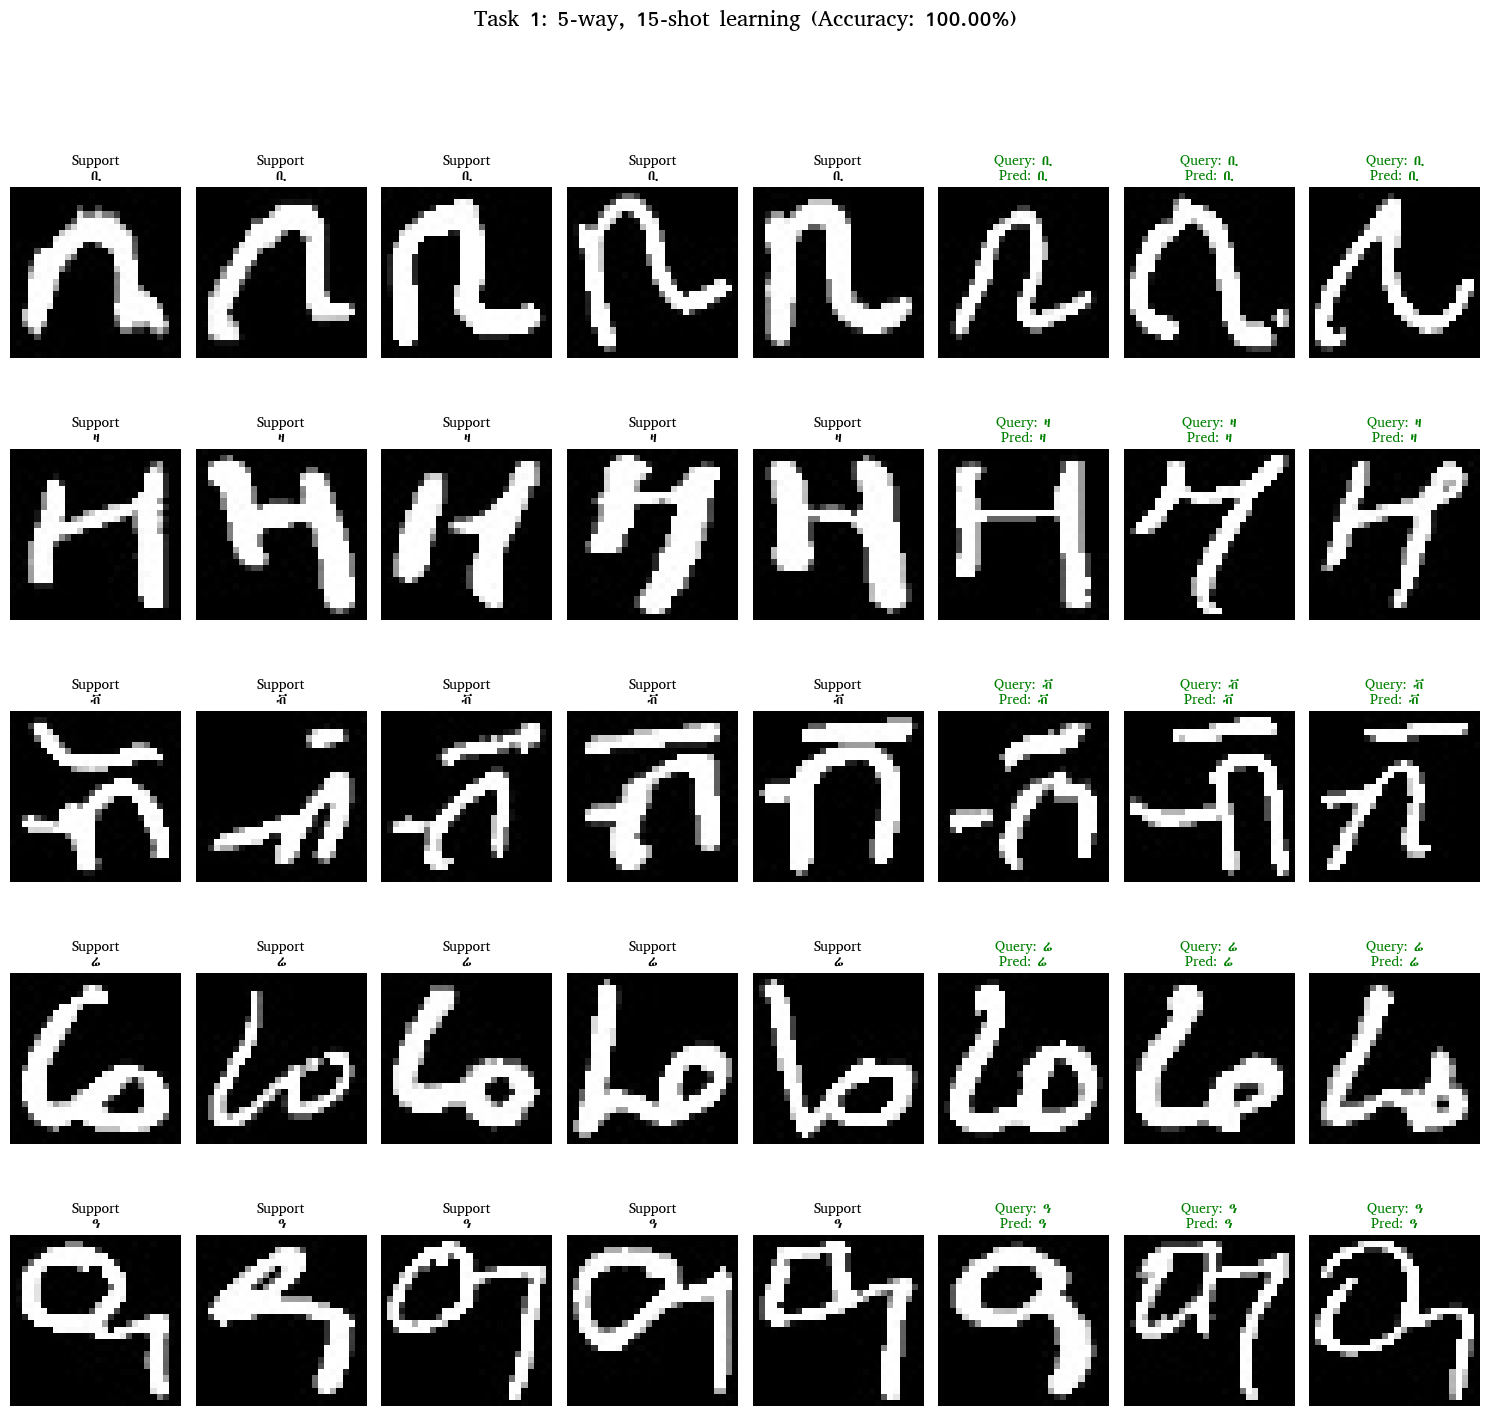


=== Task 2 ===
Class 0: ዛ
Class 1: ዬ
Class 2: ሌ
Class 3: ቢ
Class 4: ው
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ዛ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ዬ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ሌ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ቢ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ው
Task 2 Accuracy: 92.00%


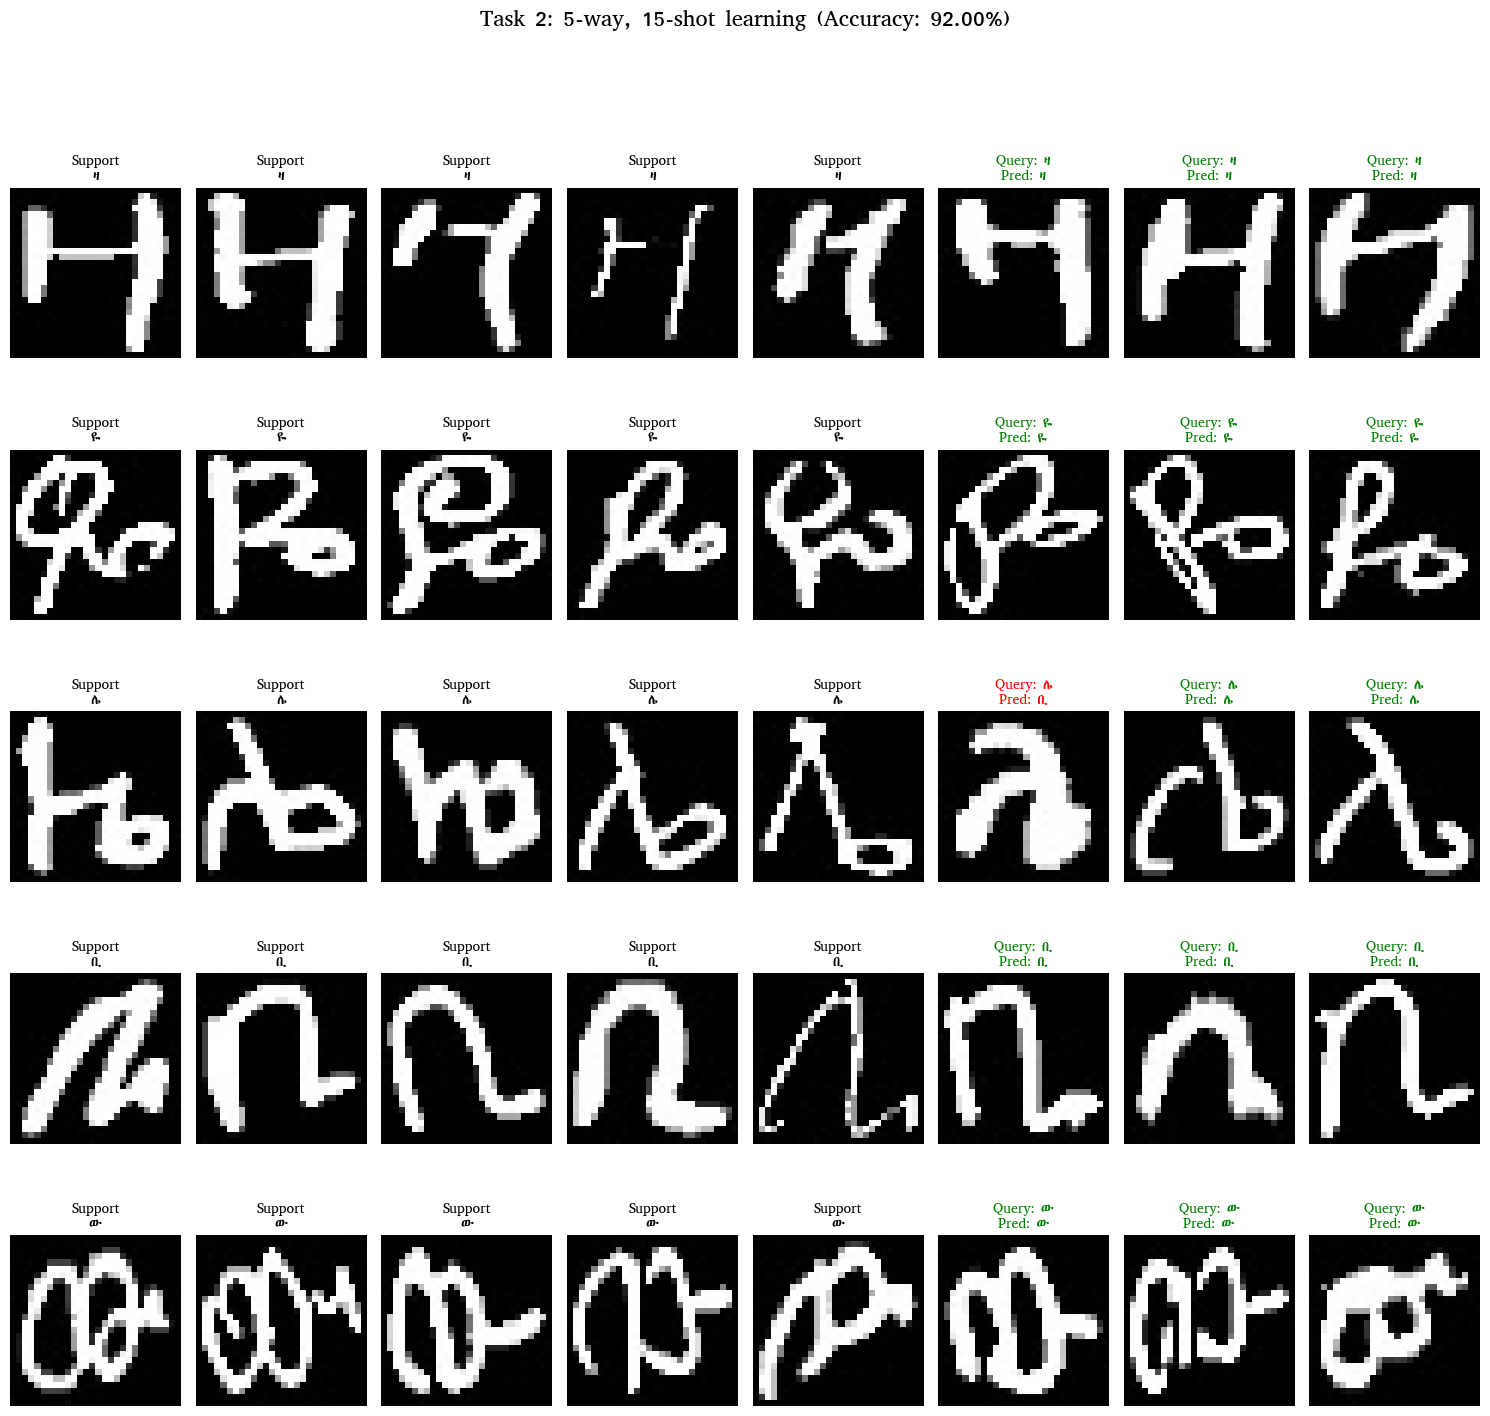


=== Task 3 ===
Class 0: ከ
Class 1: ማ
Class 2: ሆ
Class 3: ዚ
Class 4: ባ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ከ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ማ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ሆ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ዚ
Loading images from /home/hailemicaelyimer/Desktop/ACR/dataset/ባ
Task 3 Accuracy: 96.00%


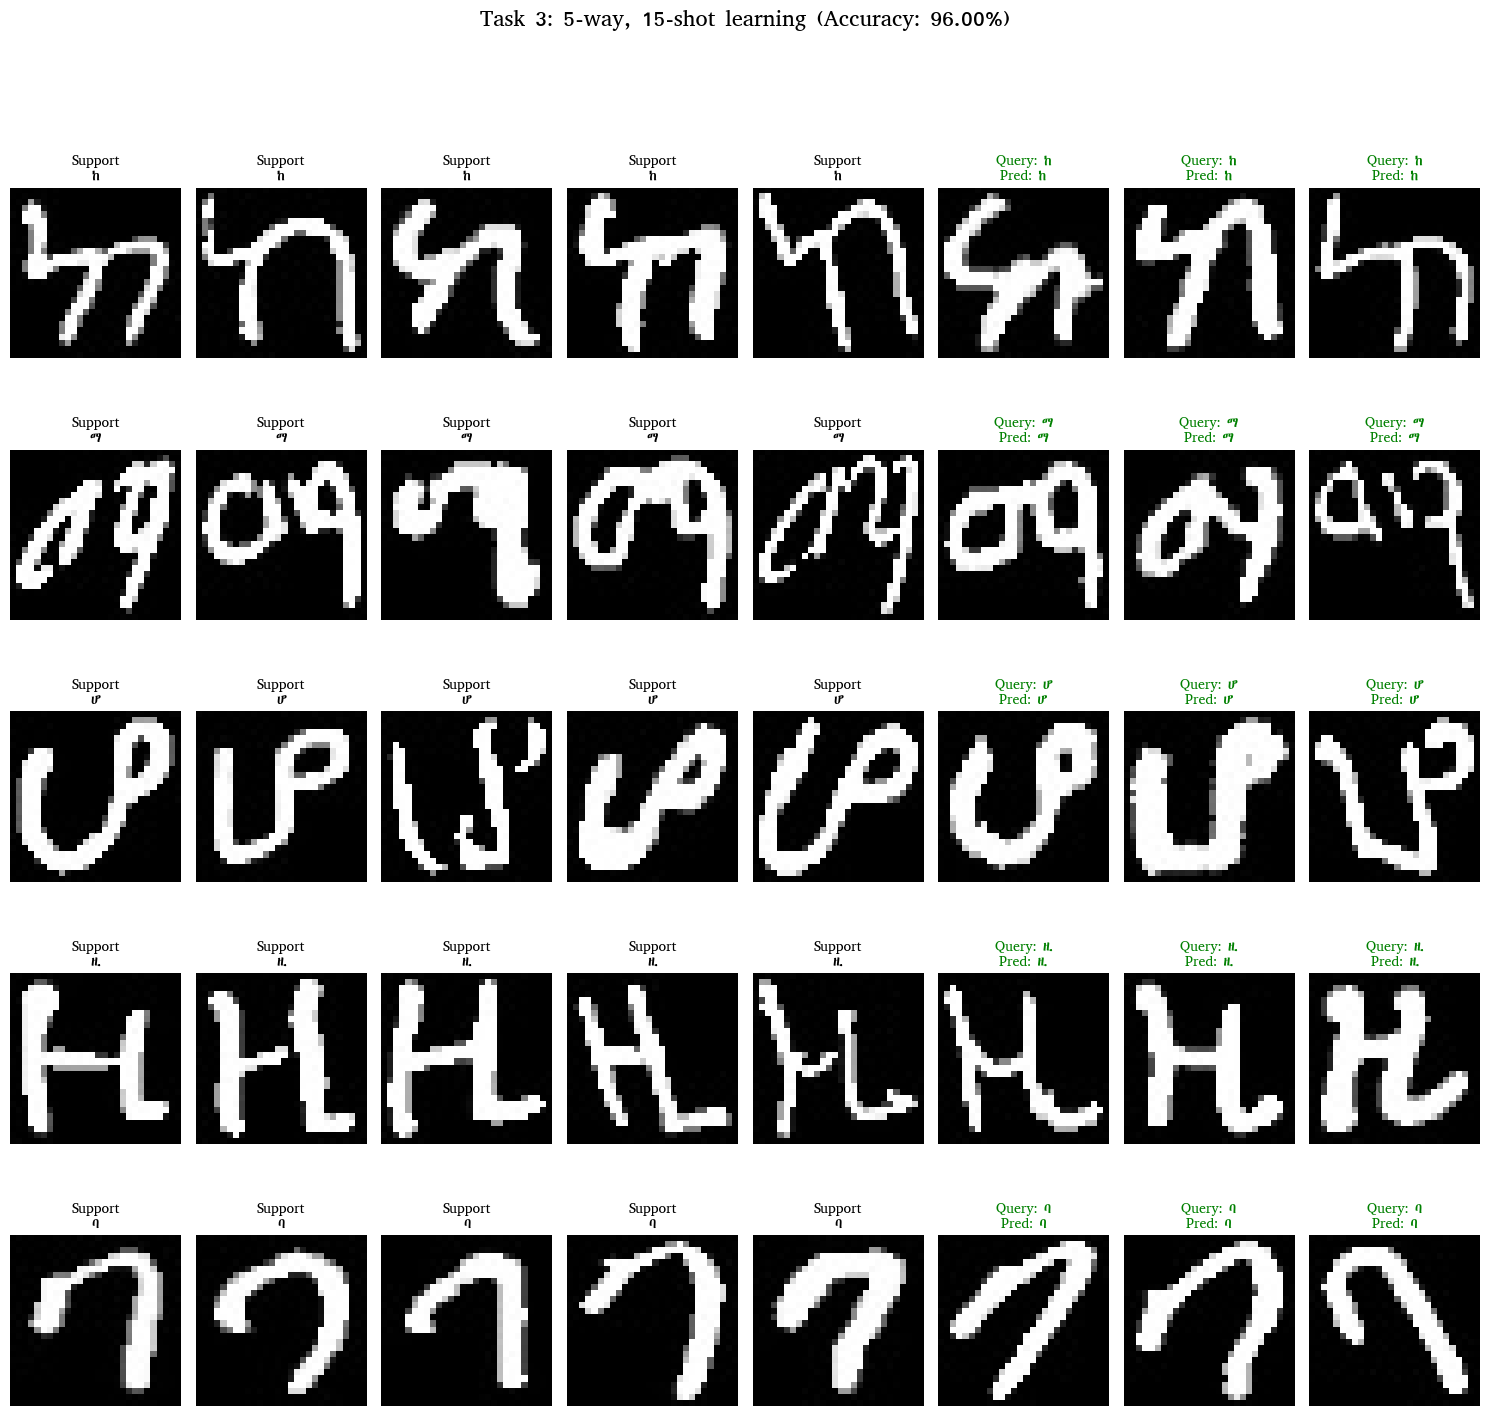

In [7]:
def visualize_predictions_robust(maml, data_generator, n_way=5, k_shot=15, q_shot=5, num_tasks=3):
    """
    A completely rewritten visualization function that correctly maps classes to characters
    and ensures proper display of Amharic characters.
    """
    # Set model to evaluation mode
    maml.model.eval()
    
    for task_idx in range(num_tasks):
        print(f"\n=== Task {task_idx+1} ===")
        
        # IMPORTANT: First, we directly sample the N classes from test folders
        # This ensures we know exactly which character maps to which class index
        sampled_test_folders = random.sample(data_generator.test_folders, n_way)
        
        # Extract actual character names (folder names) and print them
        char_names = [os.path.basename(folder) for folder in sampled_test_folders]
        for i, char in enumerate(char_names):
            print(f"Class {i}: {char}")
        
        # Now manually create the task data with the sampled classes
        all_support_images = []
        all_support_labels = []
        all_query_images = []
        all_query_labels = []
        
        # For each class, load images and assign labels
        for class_idx, class_folder in enumerate(sampled_test_folders):
            print(f"Loading images from {class_folder}")
            
            # Load all images for this character class
            all_class_images = data_generator.get_images_from_folder(
                class_folder, k_shot + q_shot, augment=False
            )
            
            # Ensure we have enough images
            if len(all_class_images) < k_shot + q_shot:
                print(f"Warning: Not enough images in {os.path.basename(class_folder)}. Found {len(all_class_images)}, need {k_shot + q_shot}.")
                # Duplicate if needed
                if len(all_class_images) > 0:
                    while len(all_class_images) < k_shot + q_shot:
                        all_class_images = torch.cat([all_class_images, all_class_images[:1]], dim=0)
                else:
                    # Create blank images if folder is empty
                    all_class_images = torch.zeros((k_shot + q_shot, 1, *data_generator.img_size), dtype=torch.float32)
            
            # Split into support and query
            support_images = all_class_images[:k_shot]
            query_images = all_class_images[k_shot:k_shot+q_shot]
            
            # Create corresponding labels
            support_labels = torch.full((k_shot,), class_idx, dtype=torch.long)
            query_labels = torch.full((q_shot,), class_idx, dtype=torch.long)
            
            # Add to task data
            all_support_images.append(support_images)
            all_support_labels.append(support_labels)
            all_query_images.append(query_images)
            all_query_labels.append(query_labels)
        
        # Combine all classes into one tensor
        all_support_images = torch.cat(all_support_images, dim=0)
        all_support_labels = torch.cat(all_support_labels, dim=0)
        all_query_images = torch.cat(all_query_images, dim=0)
        all_query_labels = torch.cat(all_query_labels, dim=0)
        
        # Adapt the model to this task
        with torch.enable_grad():
            adapted_params = maml.adapt(all_support_images, all_support_labels, first_order=True)
        
        # Evaluate on query set
        all_query_images_cuda = all_query_images.to(device)
        all_query_labels_cuda = all_query_labels.to(device)
        
        with torch.no_grad():
            query_logits = maml.forward_with_params(all_query_images_cuda, adapted_params)
            _, predicted = query_logits.max(1)
            accuracy = 100.0 * predicted.eq(all_query_labels_cuda).sum().item() / all_query_labels_cuda.size(0)
        
        print(f"Task {task_idx+1} Accuracy: {accuracy:.2f}%")
        
        # Create a figure to display results
        # Number of examples to show per class
        support_examples_to_show = 5  # Show at most 5 support examples
        query_examples_to_show = 3    # Show at most 3 query examples
        
        # Create figure and subplots
        fig, axes = plt.subplots(n_way, support_examples_to_show + query_examples_to_show, 
                               figsize=(15, 3 * n_way))
        fig.suptitle(f"Task {task_idx+1}: {n_way}-way, {k_shot}-shot learning (Accuracy: {accuracy:.2f}%)", 
                   fontsize=16)
        
        # Plot examples for each class
        for class_idx in range(n_way):
            # Get character name for this class
            char_name = char_names[class_idx]
            
            # Get support images and labels for this class
            class_support_indices = (all_support_labels == class_idx).nonzero().flatten()
            class_support_images = all_support_images[class_support_indices]
            
            # Get query images, labels, and predictions for this class
            class_query_indices = (all_query_labels == class_idx).nonzero().flatten()
            class_query_images = all_query_images[class_query_indices]
            class_query_preds = predicted[class_query_indices].cpu()
            
            # Limit the number of examples to display
            support_to_show = min(len(class_support_images), support_examples_to_show)
            query_to_show = min(len(class_query_images), query_examples_to_show)
            
            # Plot support examples
            for i in range(support_examples_to_show):
                ax = axes[class_idx, i]
                if i < support_to_show:
                    img = class_support_images[i].cpu().squeeze().numpy()
                    ax.imshow(img, cmap='gray')
                    ax.set_title(f"Support\n{char_name}", fontsize=10)
                ax.axis('off')
            
            # Plot query examples with predictions
            for i in range(query_examples_to_show):
                ax = axes[class_idx, support_examples_to_show + i]
                if i < query_to_show:
                    img = class_query_images[i].cpu().squeeze().numpy()
                    pred_class = class_query_preds[i].item()
                    pred_char = char_names[pred_class]
                    correct = pred_class == class_idx
                    
                    ax.imshow(img, cmap='gray')
                    title = f"Query: {char_name}\nPred: {pred_char}"
                    ax.set_title(title, color='green' if correct else 'red', fontsize=10)
                ax.axis('off')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.savefig(f'amharic_task_{task_idx+1}_predictions_fixed.png', dpi=300)
        plt.show()
    
    # Set model back to training mode
    maml.model.train()
def main_with_visualization():
    # Load the trained model
    SAVE_PATH = 'mamll_amharic_challenging.pth'  # Path to saved model
    N_WAY = 5
    K_SHOT = 15
    Q_SHOT = 5
    INNER_LR = 0.1
    OUTER_LR = 0.001
    INNER_STEPS = 15
    FIRST_ORDER = True
    
    # Create data generator
    data_generator = AmharicDataset(
        data_folder="/home/hailemicaelyimer/Desktop/ACR/dataset",
        img_size=(28, 28)
    )
    
    # Create and load model
    model = AmharicCNN(num_classes=N_WAY, input_channels=1)
    model = model.to(device)
    
    checkpoint = torch.load(SAVE_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Initialize MAML with loaded model
    maml = MAML(
        model=model,
        inner_lr=INNER_LR,
        outer_lr=OUTER_LR,
        inner_steps=INNER_STEPS,
        first_order=FIRST_ORDER
    )
    
    # Visualize predictions using the robust method
    print("Visualizing model predictions...")
    visualize_predictions_robust(
        maml=maml,
        data_generator=data_generator,
        n_way=N_WAY,
        k_shot=K_SHOT,
        q_shot=Q_SHOT,
        num_tasks=3  # Visualize 3 tasks
    )

# Call the function to run the visualization
if __name__ == "__main__":
    main_with_visualization()